# Load Dependency

In [1]:
import pandas as pd
import itertools,glob
from script.SelectData import get_base_index,get_selected_index
from script.TargetTransformation import ddG2ee
from script.MachineLearning import std_error,genCountMap,vis_distribution,DeltaLearningPrediction
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
random_seed = 2022

'''sel_index: Selected important index of descriptor using RFECV method. Details can be found in notebook 2'''
sel_index = [ 0,  3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21,
              23, 24, 25, 26, 27, 30, 32, 33, 34, 36, 37, 38, 39, 40, 42, 45, 46,
              52, 53, 59, 60, 61]

# Define Synthetic Space

In [2]:
dataset = pd.read_csv('../dataset.csv',index_col=0)
biaryl_smiles = dataset['Biaryl'].to_list()
olefin_smiles = dataset['Olefin'].to_list()
tdg_smiles = dataset['TDG'].to_list()
solvent_smiles = dataset['Solvent'].to_list()
additive_smiles = dataset['Additive'].to_list()
current = dataset['Current(mA)'].to_list()
temperature = dataset['Temperature'].to_list()
additive_smiles = [item if isinstance(item,str) else '' for item in additive_smiles]

biaryl_smi_set = sorted(list(set(biaryl_smiles)))
olefin_smi_set = sorted(list(set(olefin_smiles)))
tdg_smi_set = sorted(list(set(tdg_smiles)))
sol_smi_set = sorted(list(set(solvent_smiles)))
add_smi_set = sorted(list(set(additive_smiles)))
current_set = [1,1.5]
temp_set = [60]

synthetic_space = []
for item in itertools.product(biaryl_smi_set,olefin_smi_set,
    tdg_smi_set,sol_smi_set,add_smi_set,current_set,temp_set):
    synthetic_space.append(item)
synthetic_space_array = np.array(synthetic_space)
synthetic_space = pd.DataFrame.from_records(synthetic_space_array)
synthetic_space.columns = ['Biaryl','Olefin','TDG','Solvent','Additive','Current','Temperature']

print("The size of synthetic space is: %d"%len(synthetic_space))
synthetic_space

The size of synthetic space is: 889056


,Biaryl,Olefin,TDG,Solvent,Additive,Current,Temperature
0,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1,60
1,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1.5,60
2,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1,60
3,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1.5,60
4,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[Na],1,60
...,...,...,...,...,...,...,...
889051,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,O=S(=O)(O[Na])C(F)(F)F,1.5,60
889052,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1,60
889053,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1.5,60
889054,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,[Li]O[Cl+3]([O-])([O-])[O-],1,60


# Load Descriptors

In [3]:
dataset_physorg_desc = np.load('../descriptors/dataset_physorg_desc.npz')
train_x = dataset_physorg_desc['descriptors'][:,sel_index]
ddG = dataset_physorg_desc['target']

In [4]:
space_physorg_desc = []
physorg_desc_files = sorted(glob.glob('../descriptors/space/*.npz'),key=lambda x:eval(x.split('.')[-2].split('-')[-1]))
for file in physorg_desc_files:
    zload = np.load(file)
    desc = zload['descriptors']
    desc_name = zload['descriptor_names']
    space_physorg_desc.append(desc)
space_x = np.concatenate(space_physorg_desc,axis=0)[:,sel_index]
print('Shape of space descriptors:',space_x.shape)

Shape of space descriptors: (889056, 39)


# Perform Prediction over Synthetic Space

## Select Points for Training Base Model

In [5]:
for i in range(train_x.shape[1]):
    pca_sel = PCA(n_components=i,random_state=random_seed)
    train_x_sel_pca = pca_sel.fit_transform(train_x)
    if pca_sel.explained_variance_ratio_.sum() > 0.9:
        break
base_th = 8
base_index = get_base_index(train_x_sel_pca,threshold=base_th,rand_seed=random_seed)
rest_index = list(set(range(len(train_x))) - set(base_index))
base_x = train_x[base_index]
rest_x = train_x[rest_index]
base_y = ddG[base_index]
rest_y = ddG[rest_index]

## Group Points in the Synthetic Space

There are two groups of data points in the synthetic space. One group is data with existed regional data for training delta model. The other has no regional data.

In [6]:
select_th = 60

base_model_only_point_idx = []

idx2selidx_map = {}   
for idx in range(len(space_x)):
    point_x = space_x[idx].reshape(1,-1)
    point_x_sel_pca = pca_sel.transform(point_x)
    rest_x_sel_pca = pca_sel.transform(rest_x)
    sel_idx = get_selected_index(point_x_sel_pca,rest_x_sel_pca,
              method='cosine',threshold=select_th) 
    idx2selidx_map[idx] = sel_idx
    if len(sel_idx) == 0:
        base_model_only_point_idx.append(idx)
delta_model_point_idx = list(set(range(len(space_x)))-set(base_model_only_point_idx))

selidx2idxs_map = {}           
for idx in delta_model_point_idx:
    selidx = tuple(idx2selidx_map[idx])
    if not selidx in selidx2idxs_map:
        selidx2idxs_map[selidx] = [idx]
    else:
        selidx2idxs_map[selidx].append(idx)  

## Train $\Delta$-Learning Model and Perform Prediction

In [7]:
k_fold_num = 5


base_model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)
specific_model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)
point_pred_map,point_error_map = DeltaLearningPrediction(base_x,rest_x,space_x,base_y,rest_y,
                                 base_model,specific_model,base_model_only_point_idx,
                                 selidx2idxs_map,k_fold_num)

Save the prediction results

In [8]:
synthetic_space['Pred ddG'] = [point_pred_map[i] for i in point_pred_map]
synthetic_space['Pred Error'] = [point_error_map[i] for i in point_error_map]
synthetic_space.to_csv('../whole_synthetic_space_predictions.csv')

In [9]:
synthetic_space

,Biaryl,Olefin,TDG,Solvent,Additive,Current,Temperature,Pred ddG,Pred Error
0,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1,60,0.390301,0.412877
1,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,,1.5,60,0.357913,0.412877
2,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1,60,0.604465,0.311707
3,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[K],1.5,60,0.572076,0.311707
4,CCc1ccccc1-c1cc(F)ccc1C=O,C=CC(=O)NC(C)C,CC(C)(C)OC(=O)C[C@H](N)C(=O)O,CC#N.CC(=O)O,CC(=O)O[Na],1,60,0.390301,0.412877
...,...,...,...,...,...,...,...,...,...
889051,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,O=S(=O)(O[Na])C(F)(F)F,1.5,60,0.167165,0.412877
889052,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1,60,0.119442,0.412877
889053,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,[Li]OC(C)=O,1.5,60,0.094317,0.412877
889054,O=Cc1ccccc1-c1cccc2ccccc12,C=Cc1ccccc1,O=C(O)[C@@H]1CCCN1,CC(=O)O.OCC(F)(F)F,[Li]O[Cl+3]([O-])([O-])[O-],1,60,0.201577,0.412877


# Visualization

Select representative TDGs to check the ee distribution

In [11]:
_,_,_,ave_count_map = genCountMap(tdg_smi_set,synthetic_space,point_pred_map,point_error_map,species='TDG')

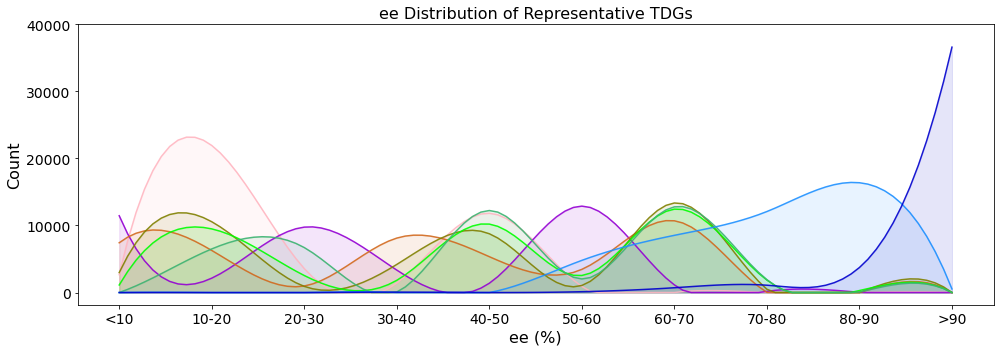

In [17]:
sel_smi_color_map = { 'O=C(O)[C@@H]1CCCN1':'#FFB6C1',   # LightPink
                      'CC(O)[C@H](N)C(=O)O':'#9400D3',   # DarkVoilet
                      'CC(C)(C)[C@H](NC(=O)C[NH3+])C(=O)O.[Cl-]':'#D2691E', # Chocolate
                      'N[C@@H](CCC(=O)O)C(=O)O':'#808000',  # Olive
                      'N[C@@H](Cc1ccccc1)C(=O)O':'#00FF00',  ## Lime
                      'CC[C@H](C)[C@H](N)C(=O)O':'#3CB371',  ## SpringGreen
                      'CC(C)(C)[C@H](N)C(=O)N[C@H](C(=O)O)C(C)(C)C':'#1E90FF',  ##DoderBlue
                      'CC(C)(C)[C@H](N)C(=O)O':'#0000CD', ## MediumBlue
                     }
vis_distribution(ave_count_map,sel_smi_color_map,title="ee Distribution of Representative TDGs")

# Validation with Experiment Results

Ten experiments in the potential synthetic space were randomly selected for validation. In addition, we also wanted these 10 trials with more widely distributed $\Delta$$\Delta$$G$

In [13]:
val_results = pd.read_csv('../space_set.csv',index_col=0)
val_ddG,val_ee = val_results['ddG'].to_numpy(),val_results['ee'].to_numpy()
val_pred_ddG = []
val_error_ddG = []
i_j_pair = {}
for i in range(len(val_results)):
    exp_item = val_results.iloc[i]
    if not isinstance(exp_item['Additive'],str):
        exp_item['Additive'] = ''
    for j in range(len(synthetic_space)):
        pred_item = synthetic_space.iloc[j]
        if pred_item['Biaryl'] == exp_item['Biaryl'] and pred_item['Olefin'] == exp_item['Olefin'] and\
           pred_item['TDG'] == exp_item['TDG'] and pred_item['Solvent'] == exp_item['Solvent'] and\
           pred_item['Additive'] == exp_item['Additive'] and eval(pred_item['Current']) == exp_item['Current'] and\
           eval(pred_item['Temperature']) == exp_item['Temperature']:
            val_pred_ddG.append(point_pred_map[j])
            val_error_ddG.append(point_error_map[j])
            i_j_pair[i] = j
            break
val_pred_ddG = np.array(val_pred_ddG)
val_error_ddG = np.array(val_error_ddG)

/home/hx-gpu1/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


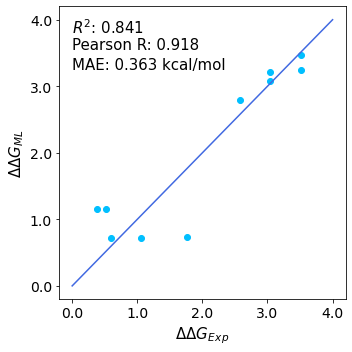

In [14]:
plt.figure(figsize=(5,5))

plt.scatter(val_ddG,val_pred_ddG,c='deepskyblue')

plt.text(0,3.8,'$R^2$: %.3f'%r2_score(val_ddG,val_pred_ddG),fontsize=15)
plt.text(0,3.55,'Pearson R: %.3f'%pearsonr(val_ddG,val_pred_ddG)[0],fontsize=15)
plt.text(0,3.25,'MAE: %.3f kcal/mol'%mean_absolute_error(val_ddG,val_pred_ddG),fontsize=15)

plt.plot([0,4],[0,4],c='royalblue')
plt.xticks([0,1,2,3,4],['0.0','1.0','2.0','3.0','4.0'],fontsize=14)
plt.yticks([0,1,2,3,4],['0.0','1.0','2.0','3.0','4.0'],fontsize=14)
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$',fontsize=15)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$',fontsize=15)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

# t-SNE for Space Sampling

Select representative data 

In [15]:
base_index = get_base_index(train_x_sel_pca,threshold=base_th,rand_seed=random_seed) 
rest_index = list(set(range(len(train_x))) - set(base_index))
rest_x = train_x[rest_index]
rest_y = ddG[rest_index]
val_space_x = space_x[[i_j_pair[i] for i in i_j_pair]]   # 10 experiments for validation
np.random.seed(random_seed)

Select regional data and perform visualization by using t-SNE method. As the randomness of t-SNE algorithm and slight difference of significant digits, the distribution of t-SNE mapping figure is different with figure shown in main text, while the selected data are same.

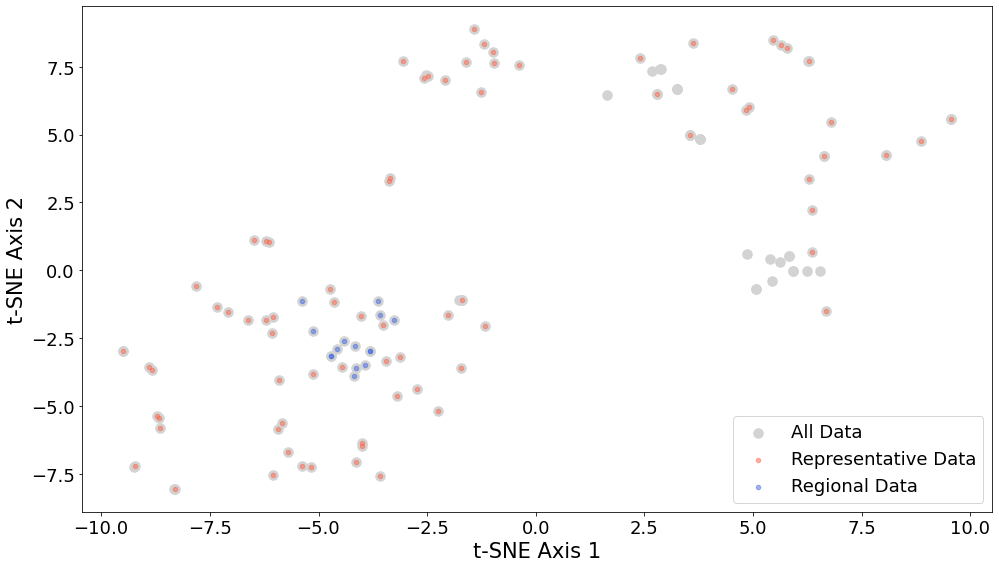

In [21]:
tsne_trans_x = np.concatenate([train_x,val_space_x])
tsne = TSNE(n_components=2)
tsne_trans_x_tsne = tsne.fit_transform(tsne_trans_x)
train_x_tsne = tsne_trans_x_tsne[:len(train_x)]
base_x_tsne = train_x_tsne[base_index]
rest_x_tsne = train_x_tsne[rest_index]
i = 0
j = i_j_pair[i]
point_x = space_x[j].reshape(1,-1)
point_x_sel_pca = pca_sel.transform(point_x)
rest_x_sel_pca = pca_sel.transform(rest_x)
sel_idx = get_selected_index(point_x_sel_pca,rest_x_sel_pca,method='cosine',threshold=select_th)
sel_x_tsne = rest_x_tsne[list(sel_idx)]

plt.figure(figsize=(14,8))
plt.scatter(train_x_tsne[:,0],train_x_tsne[:,1],c='lightgray',s=90,label='All Data')
plt.scatter(base_x_tsne[:,0],base_x_tsne[:,1],c='tomato',alpha=0.5,s=20,label='Representative Data')
plt.scatter(sel_x_tsne[:,0],sel_x_tsne[:,1],c='royalblue',alpha=0.5,s=20,label='Regional Data')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('t-SNE Axis 1',fontsize=21)
plt.ylabel('t-SNE Axis 2',fontsize=21)
plt.tick_params(bottom='on',left='on')
plt.legend(fontsize=18,loc='lower right')
plt.tight_layout()